# 1.Descarga dataset y Drive

In [ ]:
# Librerías necesarias
import pandas as pd
import sys
import gzip
import json
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
!ls /content/drive/MyDrive

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
 borrador_fernando_180624.ipynb  'Colab Notebooks'   P101   vida_laboral.pdf


In [ ]:
# Mantengo el directorio de trabajo en Colab
WORKING_PATH = '/content'
%cd {WORKING_PATH}

/content


In [ ]:
# Agrego Drive como un directorio adicional (sin cambiar el cwd)
DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks'
sys.path.append(DRIVE_PATH)


In [ ]:
# Verificar mi direcorio de trabajo
!pwd  # Debería devolver "/content"


/content


In [ ]:
# Compruebo que el archivo está .json está subido en Drive
!ls "{DRIVE_PATH}"

df_clean_subset.csv	     NLP_practica_entrenamiento_y_test.ipynb  X_test_cv_simple.pkl
df_subset.csv		     NLP_practica_Preprocesado.ipynb	      X_test.pkl
lr_model_cv_complex2.pkl     NLP_probando_subsets.ipynb		      X_test_tfidf_complex.pkl
lr_model_cv_simple2.pkl      requirements.txt			      X_test_tfidf_simple.pkl
lr_model_tfidf_complex.pkl   Sports_and_Outdoors_5.json		      X_train_cv_complex.pkl
lr_model_tfidf_simple.pkl    Sports_and_Outdoors_5.json.gz	      X_train_cv_simple.pkl
model_knn_cv_complex.pkl     subset_preprocessed.csv		      X_train.pkl
model_knn_cv_simple.pkl      test.csv				      X_train_tfidf_complex.pkl
model_knn_tfidf_complex.pkl  train.csv				      X_train_tfidf_simple.pkl
model_knn_tfidf_simple.pkl   w2v_model.model			      y_test.pkl
NLP_practica_EDA.ipynb	     X_test_cv_complex.pkl		      y_train.pkl


In [ ]:
def parse(path):
  g = gzip.open(path, 'rb') # Abre el archivo gzip en modo binario de lectura
  for l in g:
    yield json.loads(l) # convierte la línea de JSON a un diccionario de Python

def getDF(path):
  i = 0
  df = {}
  for d in parse(path): # llamamos a la función parse() para obtener línea a línea
    df[i] = d # 'i' serán las claves del diccionario
    i += 1
  return pd.DataFrame.from_dict(df, orient='index') # convertie el diccionario a dataframe

In [ ]:
df_full = getDF('/content/drive/MyDrive/Colab Notebooks/Sports_and_Outdoors_5.json.gz')

# 2.Eliminación valores

In [ ]:
df_full = df_full[['overall', 'reviewText']]
df_full.head()

,overall,reviewText
0,5.0,What a spectacular tutu! Very slimming.
1,1.0,What the heck? Is this a tutu for nuns? I know...
2,5.0,Exactly what we were looking for!
3,5.0,I used this skirt for a Halloween costume and ...
4,4.0,This is thick enough that you can't see throug...


In [ ]:
# Eliminamos las instancias que tienen valores nulos
df_full.dropna(inplace=True)
df_full.isnull().sum()

,0
overall,0
reviewText,0


# 3.Generación etiqueta de sentimiento

In [ ]:
# Creamos las clases 0 negativo y 1 poitivo
def label_sentiment(rating):
  if rating in [1,2,3]:
    return 0
  else:
    return 1


In [ ]:
# Aplicmaos al dataset
df_full['sentiment'] = df_full['overall'].apply(label_sentiment)
df_full.head()

,overall,reviewText,sentiment
0,5.0,What a spectacular tutu! Very slimming.,1
1,1.0,What the heck? Is this a tutu for nuns? I know...,0
2,5.0,Exactly what we were looking for!,1
3,5.0,I used this skirt for a Halloween costume and ...,1
4,4.0,This is thick enough that you can't see throug...,1


# 4.Creación subset BLANCEADO

In [ ]:
# Vamos a balnacear el subset
df_positive = df_full[df_full['sentiment'] == 1]
df_negative = df_full[df_full['sentiment'] == 0]





In [ ]:
print(f' shape dataset: {df_full.shape}')
print(f' shape dataset positive: {df_positive.shape}')
print(f' shape dataset negative: {df_negative.shape}')

 shape dataset: (2838826, 3)
 shape dataset positive: (2415888, 3)
 shape dataset negative: (422938, 3)


In [ ]:
# Muestra aleatoria de 15,000 instancias de cada clase
df_positive_sample = df_positive.sample(n=15000)  # random_state para reproducibilidad
df_negative_sample = df_negative.sample(n=15000)

print(f'Shape of df_positive_sample: {df_positive_sample.shape}')
print(f'Shape of df_negative_sample: {df_negative_sample.shape}')


Shape of df_positive_sample: (15000, 3)
Shape of df_negative_sample: (15000, 3)


In [ ]:
import pandas as pd
# Concatenar los 2 dataframes
df_balanced = pd.concat([df_positive_sample, df_negative_sample], ignore_index=True)

print(f'Shape of df_balnced: {df_balnced.shape}')


Shape of df_balnced: (30000, 3)


In [ ]:
df_balanced.value_counts('sentiment')

,count
sentiment,
0,15000
1,15000


In [ ]:
df_balanced.isnull().sum()

,0
overall,0
reviewText,0
sentiment,0


In [ ]:
# Guardamos el subset en drive.
df_balanced.to_csv('/content/drive/MyDrive/Colab Notebooks/df_balanced.csv', index=False, encoding='utf-8', sep=',')

# 5.Preprocesado

En el dataset vamos a hacer las siguientes transformaciones:
  * Codificar a código ASCII para eliminar carcateres extraños y signos de puntuación
  * Eliminar stop words
  * Lematización
  * texto a minúsculas
  * Eliminar token < 3 caracteres

In [ ]:
# Instalar librerias y modelos
!pip install -U spacy download en_core_web_sm

In [ ]:
# Importar librerias
import pandas as pd
import spacy
import unicodedata
from bs4 import BeautifulSoup
import re

# Cargar modelo en ingles pequeño
nlp = spacy.load('en_core_web_sm')

# Normalización Unicode para eliminar caracteres extraños
def unicode_normalize(text):
  return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

def token_out(token):
  return token.is_punct or token.is_digit or token.is_stop or re.match(r"[^a-zA-Z0-9]", token.text) or len(token)<3

# Función de normalización
def normalize_text(text):
    text = unicode_normalize(text)
    text = BeautifulSoup(text, "html5lib").get_text()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    # Procesar el texto con Spacy
    doc = nlp(text)
    # Normalización de tokens
    normalized_tokens = []
    for token in doc:
        # Comprobar si es un signo de puntuación o digito o stop word
        if token_out(token):
            # Continuar
            continue

        # Tratar el resto de casos
        else:
            # lametizamos y convertir en minusculas
            normalized_tokens.append(token.lemma_.lower())


    # Unir tokens normalizados
    normalized_text = " ".join(normalized_tokens)
    return normalized_text

In [ ]:
# Preprocesado columna 'reviewText' del dataset
df_balanced['reviewText'] = df_balanced['reviewText'].apply(normalize_text)
df_balanced.head()

<ipython-input-32-2de3f44265a3>:21: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  text = BeautifulSoup(text, "html5lib").get_text()


,overall,reviewText,sentiment
0,5.0,right size small help enter strain,1
1,5.0,work great,1
2,4.0,trigger pull gauge replace old model manufactu...,1
3,5.0,work great,1
4,5.0,hold kind use pilate instructor lot work home ...,1


In [ ]:
# columna 'sentiment' del dataset
df_balanced['sentiment'] = df_balanced['overall'].apply(lambda x: 1 if x >= 4 else 0)
df_balanced.head()

,overall,reviewText,sentiment
0,5.0,right size small help enter strain,1
1,5.0,work great,1
2,4.0,trigger pull gauge replace old model manufactu...,1
3,5.0,work great,1
4,5.0,hold kind use pilate instructor lot work home ...,1


In [ ]:
df_balanced['sentiment'].value_counts()

,count
sentiment,
1,15000
0,15000


In [ ]:
# Guardo el subset preprocesado
df_balanced.to_csv('/content/drive/MyDrive/Colab Notebooks/subset_balanced_preprocessed.csv')

#6.Entrenamiento

In [ ]:
df_balanced = df_balanced.dropna().drop_duplicates()

In [ ]:
print(f'el shape del dataframe es: {df_balanced.shape}')
print(f'\nvisulaización 5 primeras instancias: \n{df_balanced.head()}')
print(f'\nvisulaización 5 últimas instancias: \n{df_balanced.tail()}')

el shape del dataframe es: (28090, 3)

visulaización 5 primeras instancias: 
   overall                                         reviewText  sentiment
0      5.0                 right size small help enter strain          1
1      5.0                                         work great          1
2      4.0  trigger pull gauge replace old model manufactu...          1
4      5.0  hold kind use pilate instructor lot work home ...          1
5      5.0  haven time use think totally awesome get item ...          1

visulaización 5 últimas instancias: 
       overall                                         reviewText  sentiment
29995      2.0  looks good feel ring fit tube scope 4th bullet...          0
29996      3.0                         send laser accurate expect          0
29997      3.0  order large try different color big send mediu...          0
29998      2.0  bulky heavily padded busy interior waste flap ...          0
29999      1.0                           pocket depth thin exp

In [ ]:
#División train y test
from sklearn.model_selection import train_test_split

#Estratificamos por la variable objetivo
train2, test2 = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced['sentiment'], random_state=42)

In [ ]:
print(f'el shape de train es {train2.shape}')
print(f'el shape de test es: {test2.shape}')

el shape de train es (22472, 3)
el shape de test es: (5618, 3)


In [ ]:
# Guardamos train y test en archivos .csv
train2.to_csv('/content/drive/MyDrive/Colab Notebooks/train2.csv', index=False)
test2.to_csv('/content/drive/MyDrive/Colab Notebooks/test2.csv', index=False)

##6.1 Regreión Lineal

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# defino función para guardar modelos.pkl
def save_pkl(df,file_name, path='/content/drive/MyDrive/Colab Notebooks/'):
  rute = path + file_name
  with open(rute, 'wb') as f:
    pickle.dump(df, f)

In [ ]:
# Separo las características de la variable objetivo
X_train2 = train2['reviewText']
y_train2 = train2['sentiment']

X_test2 = test2['reviewText']
y_test2 = test2['sentiment']


# Guardar los conjuntos de datos
save_pkl(y_train2, 'y_train2.pkl')
save_pkl(X_train2, 'X_train2.pkl')
save_pkl(y_test2, 'y_test2.pkl')
save_pkl(X_test2, 'X_test2.pkl')

### 6.1.1 CountVectorizer y TfidfVectorizer

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Función para evaluar diferentes valores de max_features
def evaluate_max_features(max_features_list, reviews, labels):
    results = {}
    for max_features in max_features_list:
        cv = CountVectorizer(ngram_range=(1, 3), max_features=max_features, max_df=0.95, min_df=5)
        X = cv.fit_transform(reviews)
        model = MultinomialNB()
        scores = cross_val_score(model, X, labels, cv=5)
        results[max_features] = scores.mean()
    return results

# Lista de valores de max_features a evaluar
max_features_list = [100, 500, 1000, 2000, 5000]

# Evaluar diferentes valores de max_features
results = evaluate_max_features(max_features_list, X_train2, y_train2)

# Mostrar resultados
for max_features, score in results.items():
    print(f"max_features: {max_features}, score: {score}")

max_features: 100, score: 0.701851416769758
max_features: 500, score: 0.754805492727171
max_features: 1000, score: 0.7692678261411954
max_features: 2000, score: 0.7784794458363221
max_features: 5000, score: 0.7826623162857608


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# CountVectorizer simple
count_simple = CountVectorizer()
X_train_cv_simple2 = count_simple.fit_transform(X_train2)
X_test_cv_simple2 = count_simple.transform(X_test2)

# Guardar las matrices transformadas
save_pkl(X_train_cv_simple2, 'X_train_cv_simple2.pkl')
save_pkl(X_test_cv_simple2, 'X_test_cv_simple2.pkl')

# CountVectorizer con ngrams, max_features, min_df y max_df
cv_complex2 = CountVectorizer(ngram_range=(1, 3), max_features=5000, max_df=0.95, min_df=5)
X_train_cv_complex2 = cv_complex2.fit_transform(X_train2)
X_test_cv_complex2 = cv_complex2.transform(X_test2)

save_pkl(X_train_cv_complex2, 'X_train_cv_complex2.pkl')
save_pkl(X_test_cv_complex2, 'X_test_cv_complex2.pkl')

# TfIdfVectorizer simple
tfidf_simple2 = TfidfVectorizer()
X_train_tfidf_simple2 = tfidf_simple2.fit_transform(X_train2)
X_test_tfidf_simple2 = tfidf_simple2.transform(X_test2)

save_pkl(X_train_tfidf_simple2, 'X_train_tfidf_simple2.pkl')
save_pkl(X_test_tfidf_simple2, 'X_test_tfidf_simple2.pkl')

# TfIdfVectorizer complejo
tfidf_complex2 = TfidfVectorizer(ngram_range=(1, 3), max_features=5000, max_df=0.95, min_df=5)
X_train_tfidf_complex2 = tfidf_complex2.fit_transform(X_train2)
X_test_tfidf_complex2 = tfidf_complex2.transform(X_test2)

save_pkl(X_train_tfidf_complex2, 'X_train_tfidf_complex2.pkl')
save_pkl(X_test_tfidf_complex2, 'X_test_tfidf_complex2.pkl')

In [ ]:
# Definimos función para las métricas
def print_metricas(pred, y_train2):
  print('Matriz de confusion en Train:')
  cm = confusion_matrix(y_train2, pred)
  print(cm)
  target_names = ['0', '1']
  # Graficar la matriz de confusión
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

  print('---------------------------------------------')
  print('Metricas en Train:')
  print(classification_report(y_train2, pred))

In [ ]:
# Definimos la función de entreneamiento para Regresión lineal
def model_lr(X_train2, y_train2, C, f):
  param_grid = {'C': C}
  model = LogisticRegression()
  # Crear el objeto GridSearchCV con LogisticRegression
  grid = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='accuracy')

  # Realizar el ajuste
  grid.fit(X_train2, y_train2)

  save_pkl(grid, f)

  pred = grid.predict(X_train2)
  print_metricas(pred, y_train2)

  # Imprimir los mejores parámetros encontrados
  print("Best parameters: {}".format(grid.best_params_))

### 6.1.2 Entrenamiento modelo counterVectorizer simple

Matriz de confusion en Train:
[[9946 1688]
 [1953 8885]]


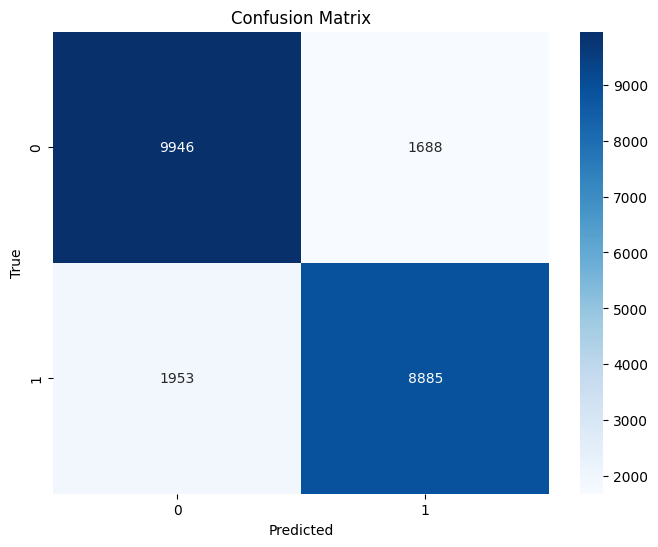

---------------------------------------------
Metricas en Train:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85     11634
           1       0.84      0.82      0.83     10838

    accuracy                           0.84     22472
   macro avg       0.84      0.84      0.84     22472
weighted avg       0.84      0.84      0.84     22472

Best parameters: {'C': 0.08858667904100823}


In [ ]:
C_vector = np.logspace(-4, 4, 20)
file_model = 'lr_model_cv_simple2.pkl'
model_lr(X_train_cv_simple2,
         y_train2,
         C_vector,
         file_model)

### 6.1.3 Entrenamiento modelo counterVectorizer complejo

Matriz de confusion en Train:
[[9995 1639]
 [1984 8854]]


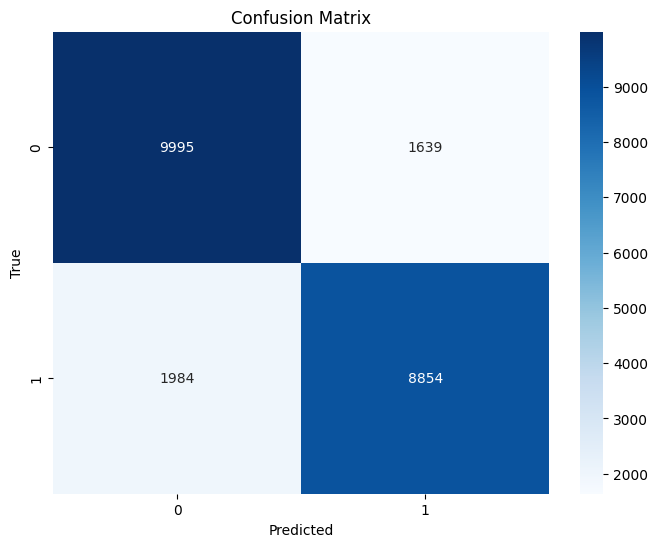

---------------------------------------------
Metricas en Train:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85     11634
           1       0.84      0.82      0.83     10838

    accuracy                           0.84     22472
   macro avg       0.84      0.84      0.84     22472
weighted avg       0.84      0.84      0.84     22472

Best parameters: {'C': 0.08858667904100823}


In [ ]:
C_vector = np.logspace(-4, 4, 20)
file_model = 'lr_model_cv_complex2.pkl'
model_lr(X_train_cv_complex2,
         y_train2,
         C_vector,
         file_model)

### 6.1.4 Entrenamiento modelo tfidfVectorizer simple

Matriz de confusion en Train:
[[10217  1417]
 [ 1605  9233]]


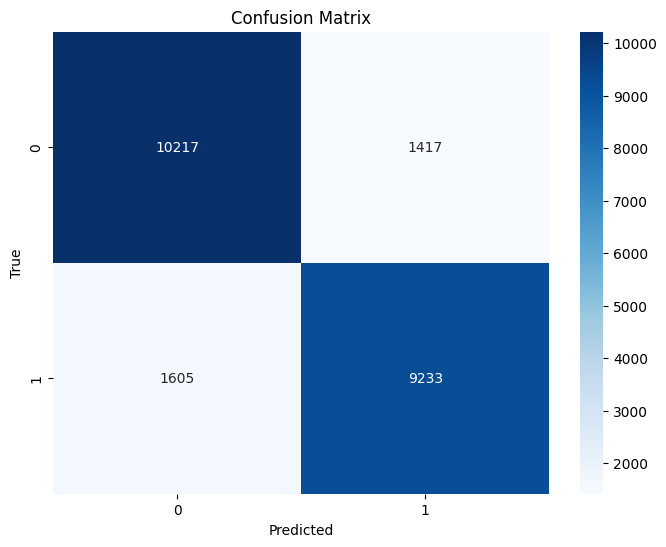

---------------------------------------------
Metricas en Train:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     11634
           1       0.87      0.85      0.86     10838

    accuracy                           0.87     22472
   macro avg       0.87      0.87      0.87     22472
weighted avg       0.87      0.87      0.87     22472

Best parameters: {'C': 2.06913808111479}


In [ ]:
C_vector = np.logspace(-6, 6, 20)
file_model = 'lr_model_tfidf_simple2.pkl'
model_lr(X_train_tfidf_simple2,
         y_train2,
         C_vector,
         file_model)

### 6.1.5 Entrenamiento modelo tfidfVectorizer complejo.

Matriz de confusion en Train:
[[10152  1482]
 [ 1715  9123]]


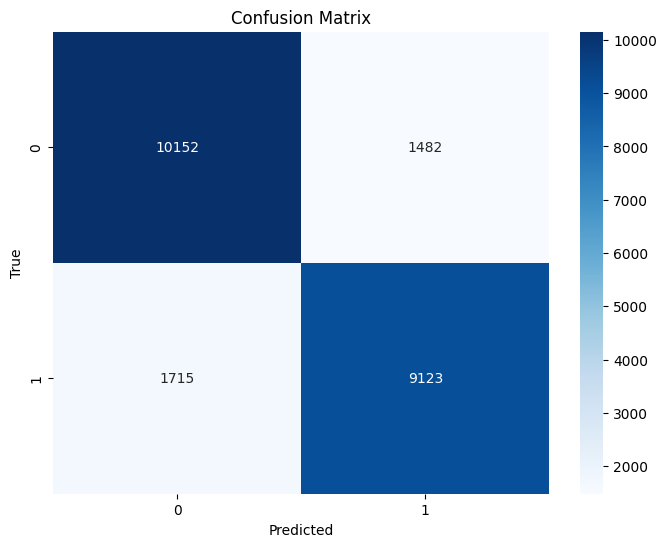

---------------------------------------------
Metricas en Train:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86     11634
           1       0.86      0.84      0.85     10838

    accuracy                           0.86     22472
   macro avg       0.86      0.86      0.86     22472
weighted avg       0.86      0.86      0.86     22472

Best parameters: {'C': 2.06913808111479}


In [ ]:
C_vector = np.logspace(-6, 6, 20)
file_model = 'lr_model_tfidf_complex2.pkl'
model_lr(X_train_tfidf_complex2,
         y_train2,
         C_vector,
         file_model)

## 6.2 Modelo KN-Neighbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np

def model_knn(X_train2, y_train2, N, f):
  param_grid = {
    'n_neighbors': N,
  }
  grid = GridSearchCV(KNeighborsClassifier(),
                      scoring= 'accuracy',
                      param_grid=param_grid, cv = 5, verbose=2)

  grid.fit(X_train2, y_train2)

  save_pkl(grid, f)

  pred = grid.predict(X_train2)
  print_metricas(pred, y_train2)

  print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
  print("best parameters: {}".format(grid.best_params_))

  scores = np.array(grid.cv_results_['mean_test_score'])
  stdvalues = np.array(grid.cv_results_['std_test_score'])

  plt.figure(figsize=(10, 6))
  plt.plot(N, scores, '-o')
  plt.errorbar(N, scores, yerr=stdvalues, fmt='o', ecolor='g', capsize=5)
  plt.xlabel('# Neighbors')
  plt.ylabel('5-Fold Accuracy')
  plt.title('K-Neighbors Classifier Performance')
  plt.grid()
  plt.show()

  print("acc (train): {:.2f}".format(grid.score(X_train2, y_train2)))

### 6.2.1 Entrenamiento modelo counterVectorizer simple

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ......................................n_neighbors=1; total time=   9.9s
[CV] END ......................................n_neighbors=1; total time=   3.9s
[CV] END ......................................n_neighbors=1; total time=   3.9s
[CV] END ......................................n_neighbors=1; total time=   9.0s
[CV] END ......................................n_neighbors=1; total time=   4.3s
[CV] END ......................................n_neighbors=2; total time=   3.0s
[CV] END ......................................n_neighbors=2; total time=   3.3s
[CV] END ......................................n_neighbors=2; total time=   3.4s
[CV] END ......................................n_neighbors=2; total time=   3.0s
[CV] END ......................................n_neighbors=2; total time=   2.8s
[CV] END ......................................n_neighbors=3; total time=   3.2s
[CV] END ......................................

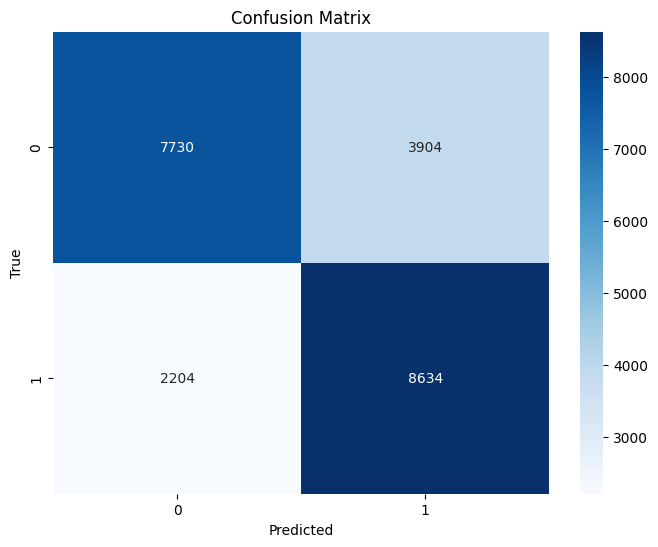

---------------------------------------------
Metricas en Train:
              precision    recall  f1-score   support

           0       0.78      0.66      0.72     11634
           1       0.69      0.80      0.74     10838

    accuracy                           0.73     22472
   macro avg       0.73      0.73      0.73     22472
weighted avg       0.73      0.73      0.73     22472

best mean cross-validation score: 0.679
best parameters: {'n_neighbors': 18}


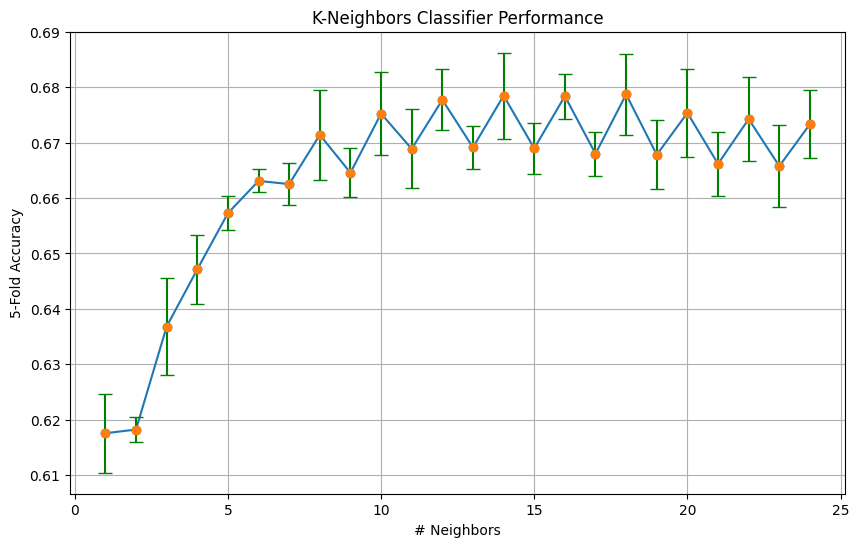

acc (train): 0.73


In [ ]:
neighbours = np.arange(1, 25, 1)
file_model = 'model_knn_cv_simple.pkl'
model_knn(X_train_cv_simple2, y_train2, neighbours,file_model)

### 6.2.2 Entrenamiento modelo counterVectorizer complejo

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END ......................................n_neighbors=1; total time=   3.0s
[CV] END ......................................n_neighbors=1; total time=   3.3s
[CV] END ......................................n_neighbors=1; total time=   2.7s
[CV] END ......................................n_neighbors=1; total time=   3.9s
[CV] END ......................................n_neighbors=1; total time=   3.9s
[CV] END ......................................n_neighbors=2; total time=   4.2s
[CV] END ......................................n_neighbors=2; total time=   4.5s
[CV] END ......................................n_neighbors=2; total time=   3.9s
[CV] END ......................................n_neighbors=2; total time=   3.8s
[CV] END ......................................n_neighbors=2; total time=   4.3s
[CV] END ......................................n_neighbors=3; total time=   3.9s
[CV] END ......................................n

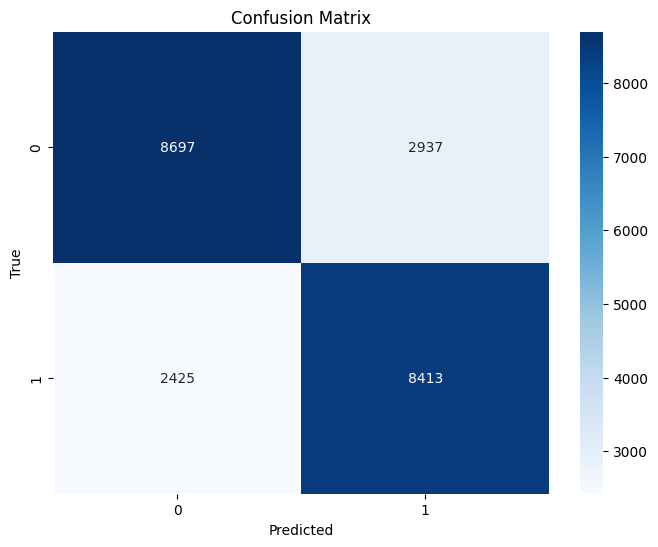

---------------------------------------------
Metricas en Train:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76     11634
           1       0.74      0.78      0.76     10838

    accuracy                           0.76     22472
   macro avg       0.76      0.76      0.76     22472
weighted avg       0.76      0.76      0.76     22472

best mean cross-validation score: 0.667
best parameters: {'n_neighbors': 8}


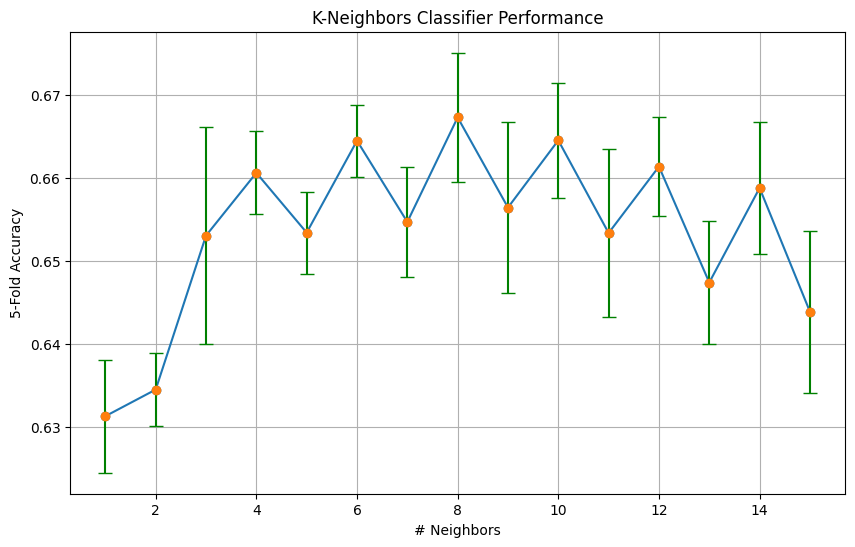

acc (train): 0.76


In [ ]:
neighbours = np.arange(1, 16, 1)
file_model = 'model_knn_cv_complex2.pkl'
model_knn(X_train_cv_complex2,
          y_train2,
          neighbours,
          file_model)

### 6.2.3 Entrenamiento modelo tfidfVectorizer simple

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END ......................................n_neighbors=1; total time=   3.6s
[CV] END ......................................n_neighbors=1; total time=   2.9s
[CV] END ......................................n_neighbors=1; total time=   3.2s
[CV] END ......................................n_neighbors=1; total time=   3.1s
[CV] END ......................................n_neighbors=1; total time=   3.5s
[CV] END ......................................n_neighbors=2; total time=   7.7s
[CV] END ......................................n_neighbors=2; total time=   4.5s
[CV] END ......................................n_neighbors=2; total time=   4.0s
[CV] END ......................................n_neighbors=2; total time=   5.6s
[CV] END ......................................n_neighbors=2; total time=   2.9s
[CV] END ......................................n_neighbors=3; total time=   2.9s
[CV] END ......................................n

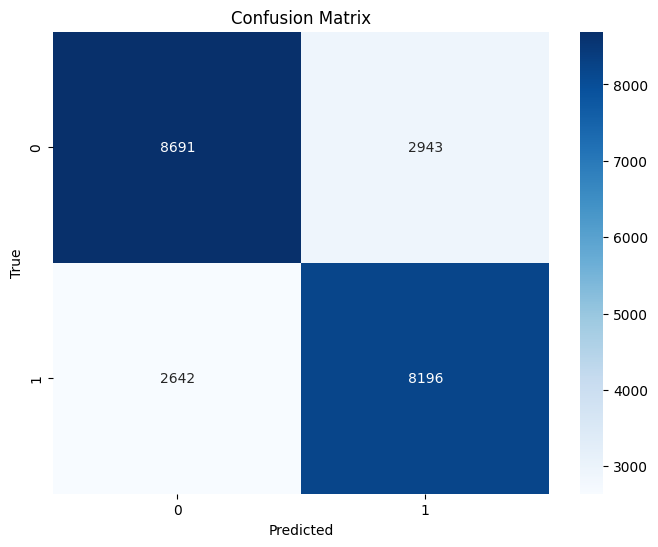

---------------------------------------------
Metricas en Train:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     11634
           1       0.74      0.76      0.75     10838

    accuracy                           0.75     22472
   macro avg       0.75      0.75      0.75     22472
weighted avg       0.75      0.75      0.75     22472

best mean cross-validation score: 0.683
best parameters: {'n_neighbors': 14}


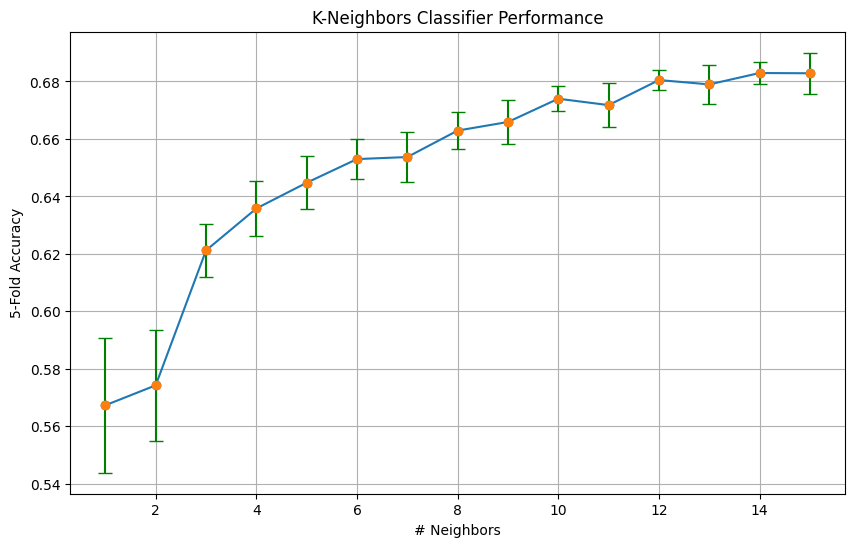

acc (train): 0.75


In [ ]:
neighbours = np.arange(1,16, 1)
file_model = 'model_knn_tfidf_simple2.pkl'
model_knn(X_train_tfidf_simple2,
          y_train2,
          neighbours,
          file_model)

### 6.2.4 Entrenamiento modelo tfidfVectorizer complejo.

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END ......................................n_neighbors=1; total time=   3.0s
[CV] END ......................................n_neighbors=1; total time=   3.0s
[CV] END ......................................n_neighbors=1; total time=   3.0s
[CV] END ......................................n_neighbors=1; total time=   2.7s
[CV] END ......................................n_neighbors=1; total time=   2.5s
[CV] END ......................................n_neighbors=2; total time=   3.2s
[CV] END ......................................n_neighbors=2; total time=   3.2s
[CV] END ......................................n_neighbors=2; total time=   3.2s
[CV] END ......................................n_neighbors=2; total time=   2.6s
[CV] END ......................................n_neighbors=2; total time=   2.9s
[CV] END ......................................n_neighbors=3; total time=   3.0s
[CV] END ......................................n

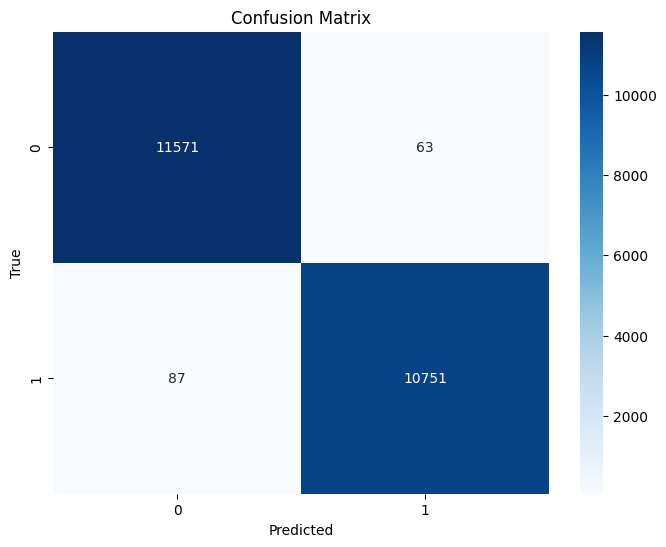

---------------------------------------------
Metricas en Train:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     11634
           1       0.99      0.99      0.99     10838

    accuracy                           0.99     22472
   macro avg       0.99      0.99      0.99     22472
weighted avg       0.99      0.99      0.99     22472

best mean cross-validation score: 0.585
best parameters: {'n_neighbors': 1}


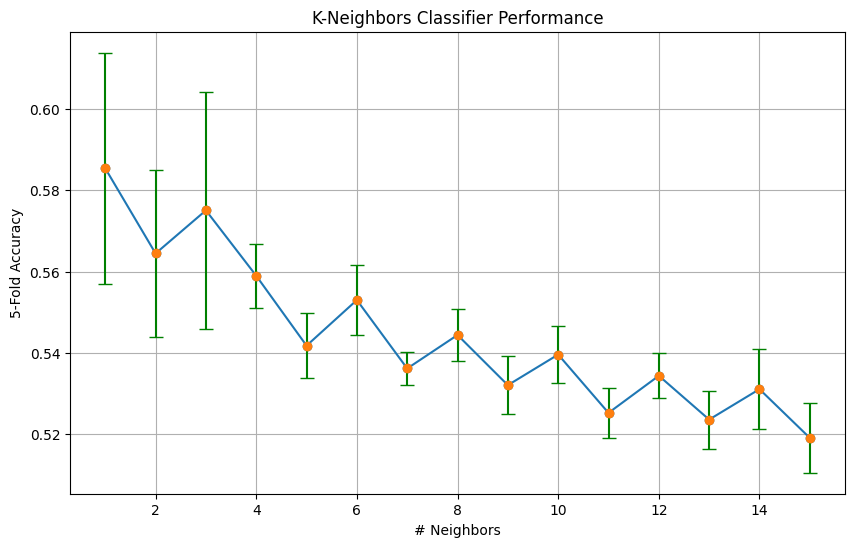

acc (train): 0.99


In [ ]:
neighbours = np.arange(1, 16, 1)
file_model = 'model_knn_tfidf_complex2.pkl'
model_knn(X_train_tfidf_complex2,
          y_train2,
          neighbours,
          file_model)

7. Conclusiones

En este proyecto de NLP se han evaluado diferentes enfoques de vectorización (CountVectorizer y TfidfVectorizer) junto con dos modelos de clasificación (Regresión Logística y K-Vecinos).

Los modelos basados en Regresión Logística han mostrado un desempeño estable, con precisiones en torno al 84-87%, siendo TfidfVectorizer la mejor opción debido a su mejor manejo de palabras frecuentes.

Sin embargo, el último modelo (K-Vecinos con TfidfVectorizer complejo) muestra una precisión anormalmente alta (99%), lo que sugiere un sobreajuste extremo. Este resultado probablemente se debe a que:

K-Vecinos es muy sensible a la dimensionalidad y el TfidfVectorizer complejo genera una representación muy detallada de los textos.
Falta de regularización y ajuste de hiperparámetros, permitiendo que el modelo memorice en lugar de generalizar.
Posible fuga de datos, donde información del conjunto de entrenamiento está filtrándose en el proceso de evaluación